In [1]:
import collections
import threading
import csv
from typing import List, Tuple

num_badnode = 0;
d=0.85
bad_nodes=[]

class Vertex():

    def __init__(self, vertex_id, trustrank):
        self.id = vertex_id
        self.trustrank = trustrank
        self.incoming_messages = []
        self.outgoing_edges = set()
        self.active = True

    def add_edge(self, neighbor):
        self.outgoing_edges.add(neighbor)

    def update(self):
        #print(self.incoming_messages)
        trust_sum = sum([message[1] for message in self.incoming_messages])/(len(self.incoming_messages)+1)
        new_trustrank = 0.15*self.trustrank + 0.85 * trust_sum
        self.active = abs(new_trustrank - self.trustrank) > 0.001
        self.trustrank = new_trustrank
        if self.id in bad_nodes:
            self.trust_rank = 1/len(bad_nodes)
        for neighbor in self.outgoing_edges:
            message = (self, 1)
            neighbor.incoming_messages.append(message)

In [2]:
import threading
class Pregel():

    def __init__(self, vertices , num_workers: int):
        self.vertices = vertices
        self.num_workers = num_workers
        self.supstep=100

    def run(self):
        self.partition = self.partition_vertices()
        while self.check_active():
            if self.supstep>0:
                self.supstep-=1
                print("Superstep on")
                self.superstep()
                print("Superstep off")
                self.redistribute_messages()
                print("Redistributed ")
                top_vertices = sorted(self.vertices.values(), key=lambda v: v.trustrank, reverse=True)[:5]
                print(f"Top 10 vertices: {[(v.id, v.trustrank) for v in top_vertices]}")
            else:
                break

    def partition_vertices(self):
        partition = collections.defaultdict(list)
        for vertex in self.vertices:
            partition[self.worker(vertex)].append(vertex)
        return partition

    def worker(self, vertex):
        return hash(vertex) % self.num_workers

    def superstep(self):
        workers = []
        for vertex_list in self.partition.values():
            print("Worker on")
            #print(len(self.vertices,len(vertex_list)))
            worker = Worker(vertex_list,self.vertices)
            workers.append(worker)
            worker.start()
        for worker in workers:
            worker.join()
            print("Worker off")

    def redistribute_messages(self):
        for vertex in self.vertices.values():
            vertex.incoming_messages = []
        for vertex in self.vertices.values():
            for receiving_vertex in vertex.outgoing_edges:
                receiving_vertex.incoming_messages.append((vertex, receiving_vertex.trustrank))

    def check_active(self):
        return any([vertex.active for vertex in self.vertices.values()])

class Worker(threading.Thread):

    def __init__(self, vertices, allvertex):
        threading.Thread.__init__(self)
        self.vertices = vertices
        self.allvertex = allvertex

    def run(self):
        #print(self.vertices)
        for vertex in self.vertices:
            if self.allvertex[vertex].active:
                self.allvertex[vertex].update()


In [3]:
import pandas as pd
import networkx as nx

# read data from csv file
df = pd.read_csv('Iron_dealers_data.csv')

# create directed multigraph
G = nx.MultiDiGraph()

# add edges to graph with labels
for index, row in df.iterrows():
    G.add_edge(row['Seller ID'], row['Buyer ID'], weight=row['Value'])

# read bad nodes from csv file
bad_nodes = pd.read_csv('bad.csv')['Bad Id'].tolist()

# convert multigraph to simple graph
G_simple = nx.Graph()

for u, v, data in G.edges(data=True):
    if G_simple.has_edge(u, v):
        G_simple[u][v]['weight'] += data['weight']
    else:
        G_simple.add_edge(u, v, weight=data['weight'])

print(nx.info(G_simple))

# find any lone nodes and connect them to all bad nodes
lone_nodes = [node for node in G_simple.nodes() if G_simple.degree[node] == 0]
print(lone_nodes, bad_nodes)
if lone_nodes:
    for bad_node in bad_nodes:
        for lone_node in lone_nodes:
            G_simple.add_edge(lone_node, bad_node, weight=1/len(bad_nodes))

# print graph information
print(nx.info(G_simple))

Graph with 799 nodes and 5040 edges
[] [1309, 1259, 1568, 1147, 1393, 1039, 1210, 1042, 1045, 1256, 1668, 1163, 1007, 1034, 1832, 1099, 1488, 1801, 1076, 1944]
Graph with 799 nodes and 5040 edges


/tmp/ipykernel_3777023/1184325359.py:26: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_simple))
/tmp/ipykernel_3777023/1184325359.py:37: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(nx.info(G_simple))


In [4]:
# create dictionary of Vertex objects
vertices = {}
for node in G_simple.nodes():
    trustrank = 0
    vertex = Vertex(node, trustrank)
    #print(node)
    vertices[node] = vertex

for edge in G_simple.edges(data=True):
    src = edge[0]
    dst = edge[1]
    weight = edge[2]['weight']
    vertices[src].add_edge(vertices[dst])

with open('bad.csv') as f:
    print("bad node load on ")
    bad_nodes = csv.reader(f)
    bad_nodes = list(bad_nodes)[1:]
    num_badnode = len(bad_nodes)
    for node in bad_nodes:
        #print(node)
        vertices[float(node[0])].trustrank = 1/num_badnode
    print("bad node load off")

# calculate trust rank using Pregel algorithm
pregel = Pregel(vertices, num_workers=4)
pregel.run()

# print top 10 nodes with highest trust rank
top_vertices = sorted(vertices.values(), key=lambda v: v.trustrank, reverse=True)[:10]
print(f"Top 10 vertices: {[(v.id, v.trustrank) for v in vertices.values()]}")


/tmp/ipykernel_3777023/1567674783.py:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.id in bad_nodes:


bad node load on 
bad node load off
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.8339622641509434), (1126.0, 0.8297619047619047), (1774.0, 0.8292682926829268), (1562.0, 0.8292682926829268), (1780.0, 0.8276315789473684)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.8971051212938005), (1126.0, 0.8927438324727481), (1774.0, 0.8922312556458897), (1562.0, 0.8901512812596479), (1780.0, 0.8853282691264243)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9331566859196505), (1126.0, 0.9286359430838674), (1774.0, 0.9281045981241702), (1562.0, 0.9254865347563906), (1780.0, 0.9207790189684012)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker 

Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices

Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices

Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.9716704135131441), (1562.0, 0.9715761452742228), (1612.0, 0.9649448493980726)]
Superstep on
Worker on
Worker on
Worker on
Worker on
Worker off
Worker off
Worker off
Worker off
Superstep off
Redistributed 
Top 10 vertices: [(1134.0, 0.9774499806117545), (1780.0, 0.9731617722604066), (1774.0, 0.97167041351314

In [5]:
top_vertices = sorted(pregel.vertices.values(), key=lambda v: v.trustrank, reverse=True)
vertices=[]
for i in top_vertices:
    print(i.id, i.trustrank)
    vertices.append((i.id, i.trustrank))

1134.0 0.9774499806117545
1780.0 0.9731617722604066
1774.0 0.9716704135131441
1562.0 0.9715761452742228
1612.0 0.9649448493980726
1528.0 0.9628018108065841
1002.0 0.9596983991422893
1072.0 0.9591653874729372
1356.0 0.9570422280809399
1426.0 0.9565440701248513
1228.0 0.9539814642384383
1126.0 0.9524296831793324
1276.0 0.9520759781978962
1140.0 0.9503499171181686
1074.0 0.9502216173296016
1582.0 0.9496279841081249
1090.0 0.9487260259085415
1035.0 0.9459753223215435
1224.0 0.9458051852787538
1658.0 0.945780291002143
1535.0 0.9456200368714167
1084.0 0.9450846058382474
1056.0 0.943865317999714
1088.0 0.9416501763186582
1611.0 0.9396243725760549
1246.0 0.9381236674686863
1039.0 0.9358143445767589
2108.0 0.9344784377861766
1666.0 0.9332007088830403
1470.0 0.93212072140844
1914.0 0.9309000115072554
2184.0 0.930080237343393
1135.0 0.9294272940468367
1023.0 0.9282981302532478
1570.0 0.9281003979692302
1542.0 0.9244651397717548
1660.0 0.9243967759516318
1488.0 0.9242000486029306
1656.0 0.92311237

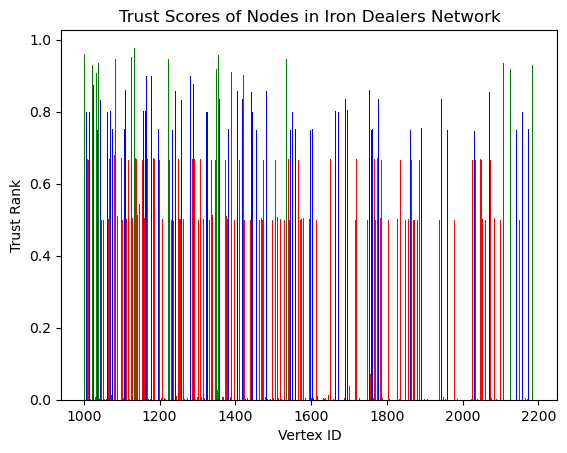

In [8]:
import matplotlib.pyplot as plt

# Split the vertices and ranks into separate lists
ver, ranks = zip(*vertices)
colors = []
for i in ranks:
    if i>0.9:
        colors.append("green")
    elif i>0.7:
        colors.append("blue")
    else:
        colors.append("red")
        

# Create a bar chart with the trust rank on the y-axis and the vertex ID on the x-axis
plt.bar(ver, ranks, color=colors)

# Set the title and axis labels
plt.title('Trust Scores of Nodes in Iron Dealers Network')
plt.xlabel('Vertex ID')
plt.ylabel('Trust Rank')


# Display the chart
plt.show()

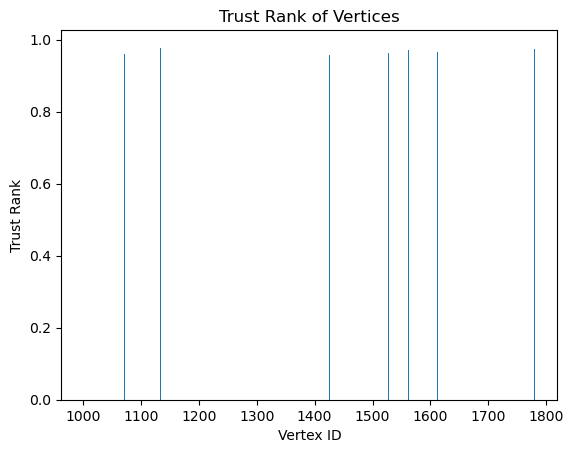

In [9]:
# Create a bar chart with the trust rank on the y-axis and the vertex ID on the x-axis
plt.bar(ver[:10], ranks[:10])

# Set the title and axis labels
plt.title('Trust Rank of Vertices')
plt.xlabel('Vertex ID')
plt.ylabel('Trust Rank')


# Display the chart
plt.show()
